In [ ]:

import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

import pymc3 as pm
import theano.tensor as tt

from google.colab import files



Primary resources for making this: 
https://docs.pymc.io/notebooks/GP-Marginal.html
https://github.com/fonnesbeck/gp_regression

Look into: 
https://docs.pymc.io/notebooks/posterior_predictive.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sparse = False
map = True


In [ ]:

data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v0.csv', delimiter=',', skip_header=1)


In [ ]:
class Sqr_root(pm.gp.mean.Mean):
    '''Custom mean func of sqr root'''
    def __init__(self, coeffs=0, intercept=0):
        pm.gp.mean.Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        return tt.squeeze(tt.dot(X**0.5, self.A) + self.b)
        #return tt.alloc(tt.add(tt.dot(tt.sqrt(X), self.A), self.B), X.shape[0])
     #   return tt.squeeze(tt.dot(X, self.A) + self.b)
     










In [ ]:


X = data[:, 1].T
y = data[:, 2].T


with pm.Model() as model:
    
    #l = pm.Uniform('l', 0, 40)
    l = pm.Normal('l', mu = 12, sigma=5)
    # change this to favour long lengthscales
    # chosing lengths and sigma over a uniform range
    sigma = pm.HalfCauchy('sigma', beta=5)
    # range of values of sigma needs to cover all data. 15 - 30 days 
    # set as a guassian with a mean of 20 with a sd of 7.5


    #mean = Sqr_root((y/X).mean()) # This is where I have the best success
    mean = Sqr_root((y/X).mean()) 
    K = sigma**2 * pm.gp.cov.ExpQuad(1, l)
    # Exp squared covariance function the 1 means 1 input dim
    if sparse:

      gp = pm.gp.MarginalSparse(cov_func=K, mean_func=mean, approx='FITC')
      
    
      Xu = pm.gp.util.kmeans_inducing_points(10, X.reshape(-1,1))

      obs = gp.marginal_likelihood("obs", X=X.reshape(-1,1), y=y, Xu=Xu, noise=sigma)

    else:
      gp = pm.gp.Marginal(cov_func=K, mean_func=mean)
      obs = gp.marginal_likelihood("obs", X=X.reshape(-1,1), y=y, noise=sigma)

    if map:
        trace = [pm.find_MAP()]
    

#print(trace)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -244.99, ||grad|| = 4.0938e-05: 100%|██████████| 23/23 [00:00<00:00, 119.99it/s] 


In [ ]:
if not map:
  with model:
    trace = pm.sample(1000, tune=2000, cores=8)
 # dont need if using find map


In [ ]:
X_pred = np.linspace(0, 13.4, num=600)[:,None]

with model:
  f_pred = gp.conditional('f_pred', X_pred.reshape(-1,1), pred_noise=True) # predict function
  pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=2500) # predicts 1000 data points?

100%|██████████| 2500/2500 [14:37<00:00,  2.85it/s]


In [ ]:
'''
x = np.array([gp.predict(X_pred, point=trace, diag=True) for i in range(100)])
gp.predict()
mu = np.mean(x[:, 0, :],axis=0)
var = np.mean(x[:, 1, :],axis=0)
'''

mu, var = gp.predict(X_pred, point=trace, diag=True, pred_noise=False)


# do this like 1000 timea?
sd = np.sqrt(var)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

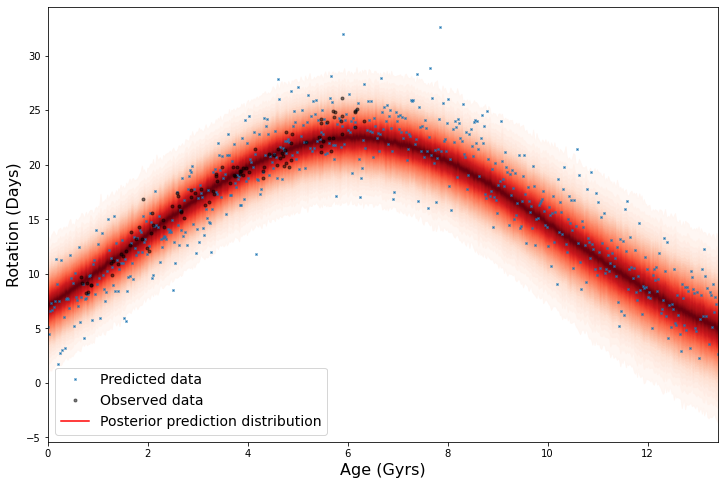

In [ ]:
fig = plt.figure(figsize=(12,8)); ax = fig.gca()
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_pred, plot_samples=False)# label='Gaussian process distribution')

plt.plot(X_pred, pred_samples["f_pred"][500, :].T, "x", ms=2, label="Predicted data")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")
#plt.plot(X_pred, mu, label='Mean function')

#plt.fill_between(X_pred.flatten(), mu - sd, mu + sd, color="r", alpha=0.5, label=r'$\pm 1\sigma$')


plt.plot(0,0, 'r', label='Posterior prediction distribution')

#plt.axvspan(min(X), max(X), alpha=0.3, color='red', label='Data region')

plt.xlim(0,13.4)

# axis labels and title
plt.xlabel("Age (Gyrs)", fontsize=16)
plt.ylabel("Rotation (Days)" ,fontsize=16)
#plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend(prop={'size': 14})

plt.savefig('2dgp.png')
files.download("2dgp.png") 


In [ ]:
print(trace)

[{'l': array(4.2435153), 'sigma_log__': array(0.93084483), 'sigma': array(2.5366513)}]
